In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf.scf import hf

import matplotlib as mpl
mpl.style.use("seaborn")
ticker = mpl.ticker

from SCFInitialGuess.utilities.analysis import density_cut, matrix_error

export_folder = "/home/jo/Repos/cc2aiPoster/densities/"


/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset

folder = "../data/"

index = np.load(folder + "index400.npy")
molecules = np.load(folder + "molecules400.npy")
S = np.load(folder + "S400.npy")
P = np.load(folder + "P400.npy")


dataset, molecules = make_butadien_dataset(
    molecules, 
    S,
    P,
    test_samples=100
)


[-] 2018-05-31 16:31:01: Data set normalized. Mean value std: 0.050517110993838175


## Pick a sample from the dataset. 
*make sure it is in the test dataset part and close to the
start of the md run!*

In [3]:
#sample_index = list(index).index(0)
#dim = 26


#mole = molecules[index].get_pyscf_molecule()
#s = S[sample_index].reshape(dim, dim)
#p = P[sample_index].reshape(dim, dim)
#mole = (molecules[0] + molecules[1])[sample_index].get_pyscf_molecule()

#sample_index

In [4]:
z_value = 3
nx = 80
ny = 80

norm = None#plt.Normalize(0, 7.6e-5)

In [5]:
from pyscf.gto import Mole

# this molecule was not in dateset!!!

mole = Mole()
mole.atom = \
"""
C        4.4041359309      1.8916107850     -0.0000000000                 
C        3.2797260633      1.1668682908     -0.0000000000                 
H        4.3930315186      2.9768518885      0.0000000000                 
H        5.3735547070      1.4032253647      0.0000000000                 
C        1.9654093058      1.7594810124     -0.0000000000                 
C        0.8403460402      1.0353923385      0.0000000000                 
H        0.8508894427     -0.0498514900      0.0000000000                 
H       -0.1287527283      1.5244026097     -0.0000000000                 
H        3.3496941836      0.0810704912      0.0000000000                 
H        1.8956795117      2.8453195832      0.0000000000  
"""

# old molecule, used to start md run.
#"""
#   C        4.33091        1.98230        0.00000
#   C        3.21425        1.24567        0.00000
#   H        4.30836        3.06736        0.00000
#   H        5.30544        1.50418        0.00000
#   C        1.89367        1.82420        0.00000
#   C        0.77642        1.08809        0.00000
#   H        0.79858        0.00302        0.00000
#   H       -0.19786        1.56668        0.00000
#   H        3.29578        0.16068        0.00000
#   H        1.81231        2.90922        0.00000
#"""


############################################################
# todo: für masterarbeit basis set hochdrehen, dann sieht man die unterschiede besser!!!!!!!

mole.basis = "sto-3g" #"6-311++g**"
mole.build()

Warn: Ipython shell catchs sys.args


In [6]:
coords = mole.atom_coords()[:, 2]
np.mean(coords), np.std(coords)

(0.0, 0.0)

# Converged 

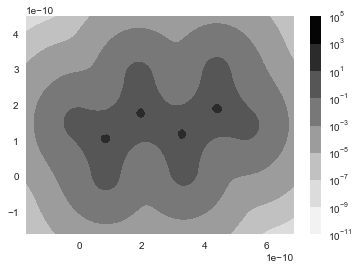

In [7]:
mf = hf.RHF(mole)
mf.verbose = 1
mf.run()

dm = mf.make_rdm1()
dm_density, x, y = density_cut(mole, dm, nx, ny, z_value=z_value)

plt.contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# H_core

In [8]:
dm_1e = hf.init_guess_by_1e(mole)
dm_1e_density, x, y = density_cut(mole, dm_1e, nx, ny, z_value=z_value)

In [9]:
np.max(dm_1e_density), np.min(dm_1e_density)


(75.92802584460802, 4.5332103359723274e-10)

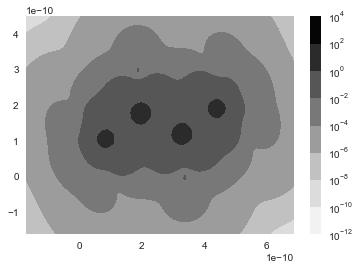

In [10]:
plt.contourf(*np.meshgrid(x, y), dm_1e_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

In [11]:
"""
for z in np.linspace(-1,5, 20):    
    dm_1e = hf.init_guess_by_1e(mole)
    dm_1e_density, x, y = density_cut(mole, dm_1e, nx, ny, z_value=z)
    plt.figure()
    plt.contourf(*np.meshgrid(x, y), dm_1e_density, locator=ticker.LogLocator())
    plt.colorbar()
    plt.title("z = " + str(z))
plt.show()
"""

'\nfor z in np.linspace(-1,5, 20):    \n    dm_1e = hf.init_guess_by_1e(mole)\n    dm_1e_density, x, y = density_cut(mole, dm_1e, nx, ny, z_value=z)\n    plt.figure()\n    plt.contourf(*np.meshgrid(x, y), dm_1e_density, locator=ticker.LogLocator())\n    plt.colorbar()\n    plt.title("z = " + str(z))\nplt.show()\n'

# SAP

In [12]:
dm_sap = hf.init_guess_by_atom(mole)
dm_sap_density, x, y = density_cut(mole, dm_sap, nx, ny, z_value)

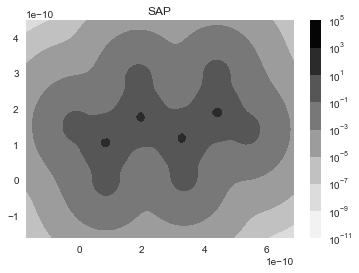

In [13]:
plt.contourf(*np.meshgrid(x, y), dm_sap_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.title("SAP")
plt.show()

# GWH

In [14]:
dm_gwh = hf.init_guess_by_wolfsberg_helmholtz(mole)
dm_gwh_density, x, y = density_cut(mole, dm_gwh, nx, ny, z_value)

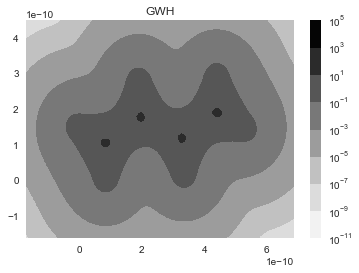

In [15]:
plt.contourf(*np.meshgrid(x, y), dm_gwh_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.title("GWH")
plt.show()

# MINAO

In [16]:
dm_minao = hf.init_guess_by_minao(mole)
dm_minao_density, x, y = density_cut(mole, dm_minao, nx, ny, z_value)

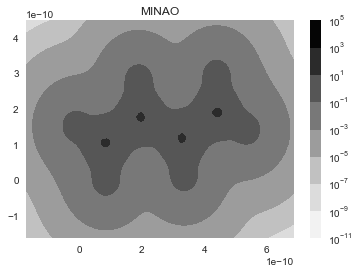

In [17]:
plt.contourf(*np.meshgrid(x, y), dm_minao_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.title("MINAO")
plt.show()

# NN

In [18]:
import tensorflow as tf
from SCFInitialGuess.nn.networks import EluFixedValue

graph = tf.Graph()

structure, weights, biases = np.load("../data/network400.npy", encoding="latin1")

with graph.as_default():
    sess = tf.Session()
    network = EluFixedValue(structure, weights, biases)
    network.setup()
    sess.run(tf.global_variables_initializer())

In [20]:
dim = 26
s = hf.get_ovlp(mole)
s_norm = dataset.input_transformation(s.reshape(-1, dim**2))

In [21]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

dm_nn = network.run(sess, s_norm).reshape(dim, dim).astype("float64")
dm_nn_density, x, y = density_cut(mole, dm_nn, nx, ny, z_value) 

In [22]:
from SCFInitialGuess.utilities.analysis import measure_idempotence_error, measure_absolute_error

print(list(measure_idempotence_error([dm_nn], [s])))

print(np.mean(np.abs(dm - dm_nn)))


[0.0033321643233725057]
0.0022715840934373617


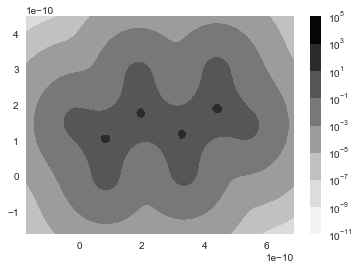

In [23]:
plt.contourf(*np.meshgrid(x, y), dm_nn_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

In [24]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

dm_mcw5 = multi_mc_wheeny(dm_nn, s, 5)
dm_mcw5_density, x, y = density_cut(mole, dm_mcw5, nx, ny, z_value) 

print(list(measure_idempotence_error([dm_mcw5], [s])))

[5.688041256868469e-17]


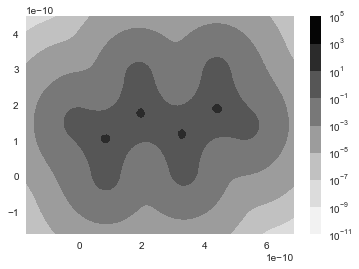

In [25]:
plt.contourf(*np.meshgrid(x, y), dm_mcw5_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# Subplot

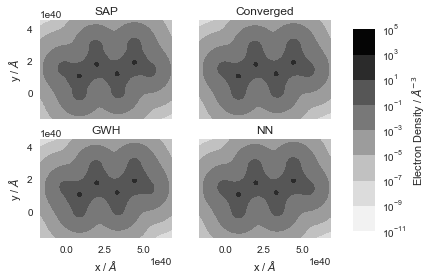

In [30]:
fig, axes = plt.subplots(2, 2)

vmin = 1e-11
vmax = 1e5

ylabel = r"y / $\AA$"
xlabel = r"x / $\AA$"

x *= 1e10
y *= 1e10

norm = plt.Normalize(vmin, vmax)

axes[0,0].contourf(*np.meshgrid(x, y), dm_sap_density, locator=ticker.LogLocator(), vmin=vmin, vmax=vmax)
axes[0,0].set_title("SAP")
axes[0,0].ticklabel_format(style='plain', axis='x')
axes[0,0].set_ylabel(ylabel)



axes[1,0].contourf(*np.meshgrid(x, y), dm_gwh_density, locator=ticker.LogLocator(), vmin=vmin, vmax=vmax)
axes[1,0].set_title("GWH")
axes[1,0].set_xlabel(xlabel)
axes[1,0].set_ylabel(ylabel)

axes[0,1].contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), vmin=vmin, vmax=vmax)
axes[0,1].set_title("Converged")
axes[0,1].ticklabel_format(style='plain')


im = axes[1,1].contourf(*np.meshgrid(x, y), dm_nn_density, locator=ticker.LogLocator(),  vmin=vmin, vmax=vmax)
axes[1,1].set_title("NN")
axes[1,1].ticklabel_format(style='plain', axis='y')
axes[1,1].set_xlabel(xlabel)

_ = plt.setp([a.get_xticklabels() for a in axes[0, :]], visible=False)
_ = plt.setp([a.get_yticklabels() for a in axes[:, 1]], visible=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
#cbar.ax.text(.5, (2 * j + 1) / 8.0, lab, ha='center', va='center')
cbar.set_label(r"Electron Density / $\AA^{-3}$")

plt.savefig(export_folder + "density_cuts.pdf")
#